## De-drifting

### Read the data

In [1]:
#path = '/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/mon/ocean/thetao/r1i1p1/'
path = '/Users/irv033/Downloads/data/'
control_files_all = path+'thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_*.nc'
control_files_pair = [path+'thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_000101-001012.nc',
                      path+'thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_001101-002012.nc']

In [2]:
import xarray

In [3]:
ds = xarray.open_mfdataset(control_files_pair, decode_cf=False)

The `decode_cf` option turns off the automatic conversion of the time axis to `numpy.datetime64` objects, which fails for the control runs because their time values don't make sense:
```
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/xarray/conventions.py:382: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)

```

In [4]:
print ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 189, lev: 31, lon: 192, time: 240)
Coordinates:
  * lev        (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat        (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * bnds       (bnds) int64 0 1
  * time       (time) float64 15.5 45.0 74.5 105.0 135.5 166.0 196.5 227.5 ...
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 59.0 59.0 90.0 90.0 120.0 ...
    lat_bnds   (time, lat, bnds) float64 -90.0 -87.71 -87.71 -86.77 -86.77 ...
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 2.812 2.812 ...
    lev_bnds   (time, lev, bnds) float64 0.0 10.0 10.0 21.62 21.62 35.14 ...
    thetao     (time, lev, lat, lon) float32 1e+20 1e+20 1e+20 1e+20 1e+20 ...
Attributes:
    institution: Australian Commonwealth Scientific and Industrial Research Organization (CSIRO) Marine and Atmospheric Research (Mel

In [5]:
print ds.time.values[0]
print ds.time.values[-1]

15.5
7284.5


In [6]:
print ds.nbytes * (2 ** -30), 'GB'
print 31 * 189 * 192, 'grid points'

1.00724588335 GB
1124928 grid points


So there is 25.2 GB of data and over a million grid points (i.e. level / lat / lon) (the former was calculated according to the conversion that Stephan Hoyer does at [this blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python)). Interestingly, if the time axis is converted to `numpy.datetime64` objects then the size blows out to 50.3 GB.

In [7]:
ds.chunks

Frozen(SortedKeysDict({u'lat': (189,), u'bnds': (2,), u'lon': (192,), u'lev': (31,), u'time': (120, 120)}))

According to [this post](http://stackoverflow.com/questions/23849097/numpy-np-apply-along-axis-function-speed-up), `numpy.apply_along_axis()` is not for speed. It gives some other more difficult options for speeding things up, but I'm thinking dask map_blocks will work if I can rechuck such that there is a chunk for every grid point...

In [8]:
rechunked = ds.chunk({'time': 240, 'lev' : 1, 'lat' : 1, 'lon' : 1})
print rechunked.chunks

Frozen(SortedKeysDict({u'lat': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), u'bnds': (2,), u'lon': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

### Figure out how the coefficient calculation works

#### Fake data

In [9]:
import numpy
import matplotlib.pyplot as plt

In [10]:
% matplotlib inline

In [11]:
x = [2.53240, 1.91110, 1.18430, 0.95784, 0.33158,
     -0.19506, -0.82144, -1.64770, -1.87450, -2.2010]

y = [-2.50400, -1.62600, -1.17600, -0.87400, -0.64900,
     -0.477000, -0.33400, -0.20600, -0.10100, -0.00600]

coefficients = numpy.polyfit(x, y, 3)

print coefficients

[-0.03663771 -0.09944278 -0.28178298 -0.53596979]


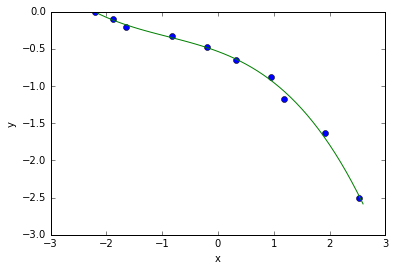

In [12]:
polynomial = numpy.poly1d(coefficients)
xs = numpy.arange(-2.2, 2.6, 0.1)
ys = polynomial(xs)

plt.plot(x, y, 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

#### Single grid point

In [28]:
ds['thetao'].missing_value

1e+20

In [52]:
darray = ds['thetao']
subset_dict = dict(lon=150, lat=-50, lev=15, method='nearest')
grid_point_data = darray.sel(**subset_dict)

In [53]:
print grid_point_data.shape
print type(grid_point_data)

(240,)
<class 'xarray.core.dataarray.DataArray'>


In [54]:
grid_point_data.values[0] == ds['thetao'].missing_value

False

In [55]:
x = grid_point_data.time.values
y = grid_point_data.values
 
a, b, c, d = numpy.polyfit(x, y, 3)
#a, b, c, d = numpy.polynomial.polynomial.polyfit(x, y, 3)

In [56]:
print a, b, c, d

-3.41035484236e-12 1.76802793978e-08 -1.36241221388e-05 281.463341664


For the expression $ax^3 + bx^2 + cx + d$, `numpy.polyfit` returns a, b, c, d, while `numpy.polynomial.polynomial.polyfit` returns d, c, b, a. I read that the polynomial one is more recent, but it doesn't seem to be any faster.

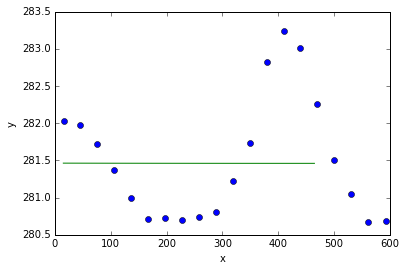

In [57]:
polynomial = numpy.poly1d([a, b, c, d])
#xs = numpy.arange(ds.time.values[0], ds.time.values[-1], 50)
xs = numpy.arange(15, 500, 50)
ys = polynomial(xs)

plt.plot(x[0:20], y[0:20], 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

#### Multiple grid points

The simplest apporach would be to write a nested for loop. I can't figure out how to make `numpy.apply_along_axis` work with this problem, but (as mentioned earlier) that function is no faster than regular looping in python so it's only use is to make your code look prettier. 

Vectorising/parallelising the code myself would be difficult, so I'd like to use dask so that it happens automatically in the background. Here goes...

In [58]:
import dask.array as da

subset_dict = dict(lon=slice(150,152), lat=slice(-50, -48), lev=15.)
multi_point_data = rechunked['thetao'].sel(**subset_dict)

dask_array = multi_point_data.data

In [59]:
print dask_array

dask.array<getitem..., shape=(240, 3, 2), dtype=float32, chunksize=(240, 1, 1)>


In [60]:
my_time_axis = rechunked.time.values
missing_value = ds['thetao'].missing_value

def my_polyfit(data):
    
    if data[0] == missing_value:
        return numpy.array([missing_value]*4)[:, None, None]
    else:    
        return numpy.polyfit(my_time_axis, data.squeeze(), 3)[:, None, None] 

In [61]:
coefficients = dask_array.map_blocks(my_polyfit, chunks=(4,1,1)).compute()

In [62]:
coefficients.shape

(4, 3, 2)

I've posted a [question on Stack Overflow](http://stackoverflow.com/questions/36275052/applying-a-function-along-an-axis-of-a-dask-array) to figure out a problem I was having with this. 

I can also confirm that it works for missing values (I re-ran the above code with lev = 4800, which has all missing values)

In [63]:
coefficients[:,:,:]

array([[[ -3.41035484e-12,  -4.88724747e-12],
        [ -3.59243236e-12,  -5.55903659e-12],
        [ -3.83090708e-12,  -6.31619906e-12]],

       [[  1.76802794e-08,   3.28260829e-08],
        [  2.05647296e-08,   4.12682150e-08],
        [  2.55556555e-08,   5.15066434e-08]],

       [[ -1.36241221e-05,  -5.03619355e-05],
        [ -3.93477344e-05,  -8.80771864e-05],
        [ -7.18479781e-05,  -1.31548251e-04]],

       [[  2.81463342e+02,   2.81530269e+02],
        [  2.81897959e+02,   2.81912931e+02],
        [  2.82301410e+02,   2.82273010e+02]]])